# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [35]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

In [64]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [65]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [66]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [6]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/121376 [00:00<?, ?it/s]

# Regress SOC mass fraction for 1/121,376 data points

In [59]:
KEndmembers = 90
NPoints = 1
#NData = dataI.shape[0]
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [55]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

### Pull f_{SOC} and m's, generate seed m's and alphas

In [56]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF) # + 10000.0*omrs
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.bdsFLoss[self.epoch] = oobsF.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

In [67]:
import pickle

rrs=[]
socspecs = np.zeros([MSpectra,1501])
ms = np.zeros([100,KEndmembers-1,1501])

offset=0

with open('results/step3/step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)
        rrs += [model.rrsoc.detach().item()]
        socspecs[:,0] = np.array(model.fsoc.tolist())

        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1 - msoc)).T 

        ms[:,:,0] = tcorrms

        print(model.rrsoc.detach().item())

for i in range(1500) :

    with open('results/step3/step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

        rrs += [model.rrsoc.detach().item()]

        socspecs[:,i+1] = np.array(model.fsoc.tolist())
        if np.sum(np.isnan(socspecs[:,i+1]).astype('float32')) > 0 :
            print("Spectrum ",i,"is NaN.")

        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 

        ms[:,:,i+1] = tcorrms

socspecs[:,861]  = socspecs[:,862]
socspecs[:,1046] = socspecs[:,1047]
rrs[861]   = rrs[862]
rrs[1046]  = rrs[1047]
ms[:,:,861]  = ms[:,:,862]
ms[:,:,1046] = ms[:,:,1047]

def getSeedMs() :

    fsoc = np.mean(socspecs,axis=1).tolist()
    F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
    F = np.array(F + [fsoc])
    fsoc = np.array(fsoc)

    seedrrsoc = np.mean(np.array(rrs))
    seedMs    = np.mean(ms,axis=(0,2)) # covers all seedMs but msoc
    seedMsoc  = np.mean(sample_soc)/100.0 
    seedMs = np.append(seedMs,seedMsoc)
    
    return seedMs, seedrrsoc, seedMsoc

0.784228800646419
Spectrum  860 is NaN.
Spectrum  1045 is NaN.


In [68]:
seedMs, seedrrsoc, seedMsoc = getSeedMs()

In [69]:
seedrrsoc

0.7588449063508054

/tmp/ipykernel_993077/609878326.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,np.max(sample_soc)*1.1])


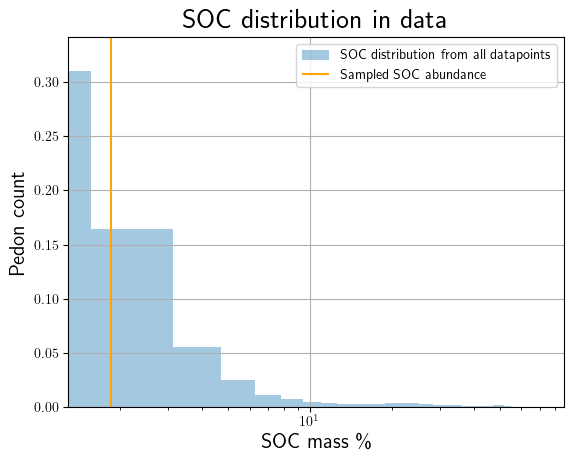

In [59]:
dataIndices = np.random.choice(NData,NPoints,replace=False)
msoc = sample_soc[dataIndices]

th=plt.hist(sample_soc, bins=50, density=True, alpha=0.4, label='SOC distribution from all datapoints')
plt.vlines(msoc, ymin=0,ymax=np.max(th[0])*1.1, alpha=1, color='orange', label='Sampled SOC abundance')
plt.xlabel("SOC mass \%",fontsize=15)
plt.ylabel("Pedon count",fontsize=15)
plt.title("SOC distribution in data",fontsize=20)
plt.xscale('log')

plt.xlim([0,np.max(sample_soc)*1.1])
plt.ylim([0,np.max(th[0])*1.1])
plt.legend()
plt.grid()

msoc=msoc/100.0

### Generate SOC seed F for reference

In [ ]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [ ]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

### Generate reflectance pseudodata from mixing model

In [101]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA)).t()

rhorads = np.array(rhos)*np.array(rads)
seedAs = A(seedMs,np.append(rhorads,seedrrsoc))

In [102]:
np.sum(seedMs)

1.0000032560047827

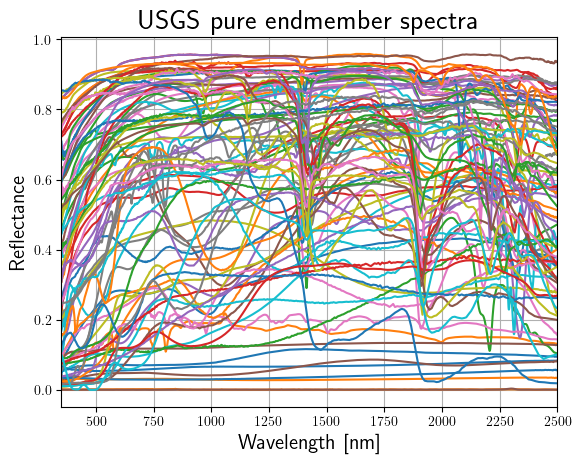

In [103]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

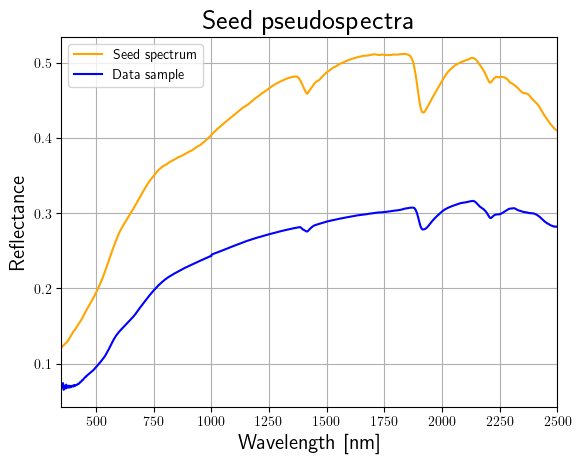

In [104]:
plt.plot(XF,np.dot(seedAs,F).T, color='orange', label='Seed spectrum');
plt.plot(XF,dataI[dataIndices].T, color='blue',label='Data sample');
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.legend()
plt.grid()

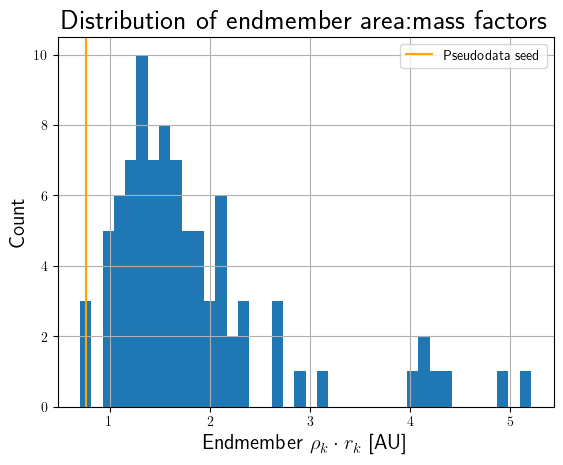

In [105]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of endmember area:mass factors',fontsize=20)
plt.grid()

#plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Pseudodata mean');
plt.vlines(seedrrsoc,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Pseudodata seed');
#ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

### Run fit

In [36]:
class LinearMixingSOCPredictor(nn.Module):
    def __init__(self, seedFs, seedMs, trueMsoc, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad;
        self.fs     = seedFs;
        self.truemsoc = trueMsoc;
        
        # model parameters
        self.rrsoc  = nn.Parameter(seedrrsoc);
        self.ms     = nn.Parameter(seedMs);
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.socbias = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        rrFull    = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        mFull     = (self.ms.t() / torch.sum(self.ms)).t()
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),self.fs.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.Ihat) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.Ihat)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((y - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA)
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.socbias[self.epoch]  = self.truemsoc - mFull[-1];
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

In [107]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F.tolist())
tseedMs  = torch.tensor(seedMs.tolist())
tmsoc    = torch.tensor(msoc)
trhorads = torch.tensor(rhorads.tolist())
trrsoc   = torch.tensor(seedrrsoc)

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = torch.tensor(dataI[dataIndices])

nepochs = 20000
model = LinearMixingSOCPredictor(tF, tseedMs, tmsoc, trhorads, trrsoc, nepochs)
optimizer = optim.Adam(model.parameters(), lr = 0.000005, betas=(0.99,0.999))

for epoch in tqdm(range(nepochs)) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.01 ** 2) / (NPoints*MSpectra))

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch  19999 :  0.0007158684893511236 0.0006009259377606213 0.0027937049640196247


0.7722081225635634 1.5204527799175653 1.8363792196655018


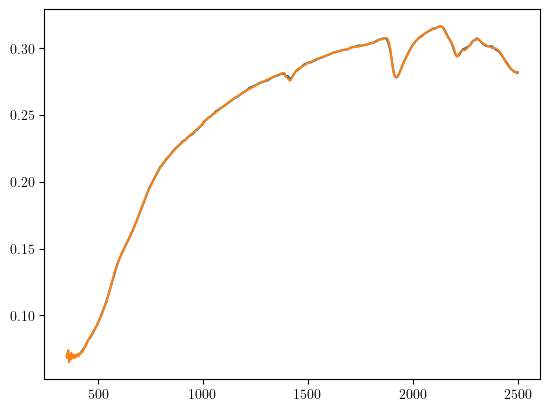

In [108]:
plt.plot(XF,model.Ihat.detach().numpy().T);
plt.plot(XF,dataI[dataIndices].T);
print(model.rrsoc.detach().item(),seedSOCrr[0],trueSOCrr)

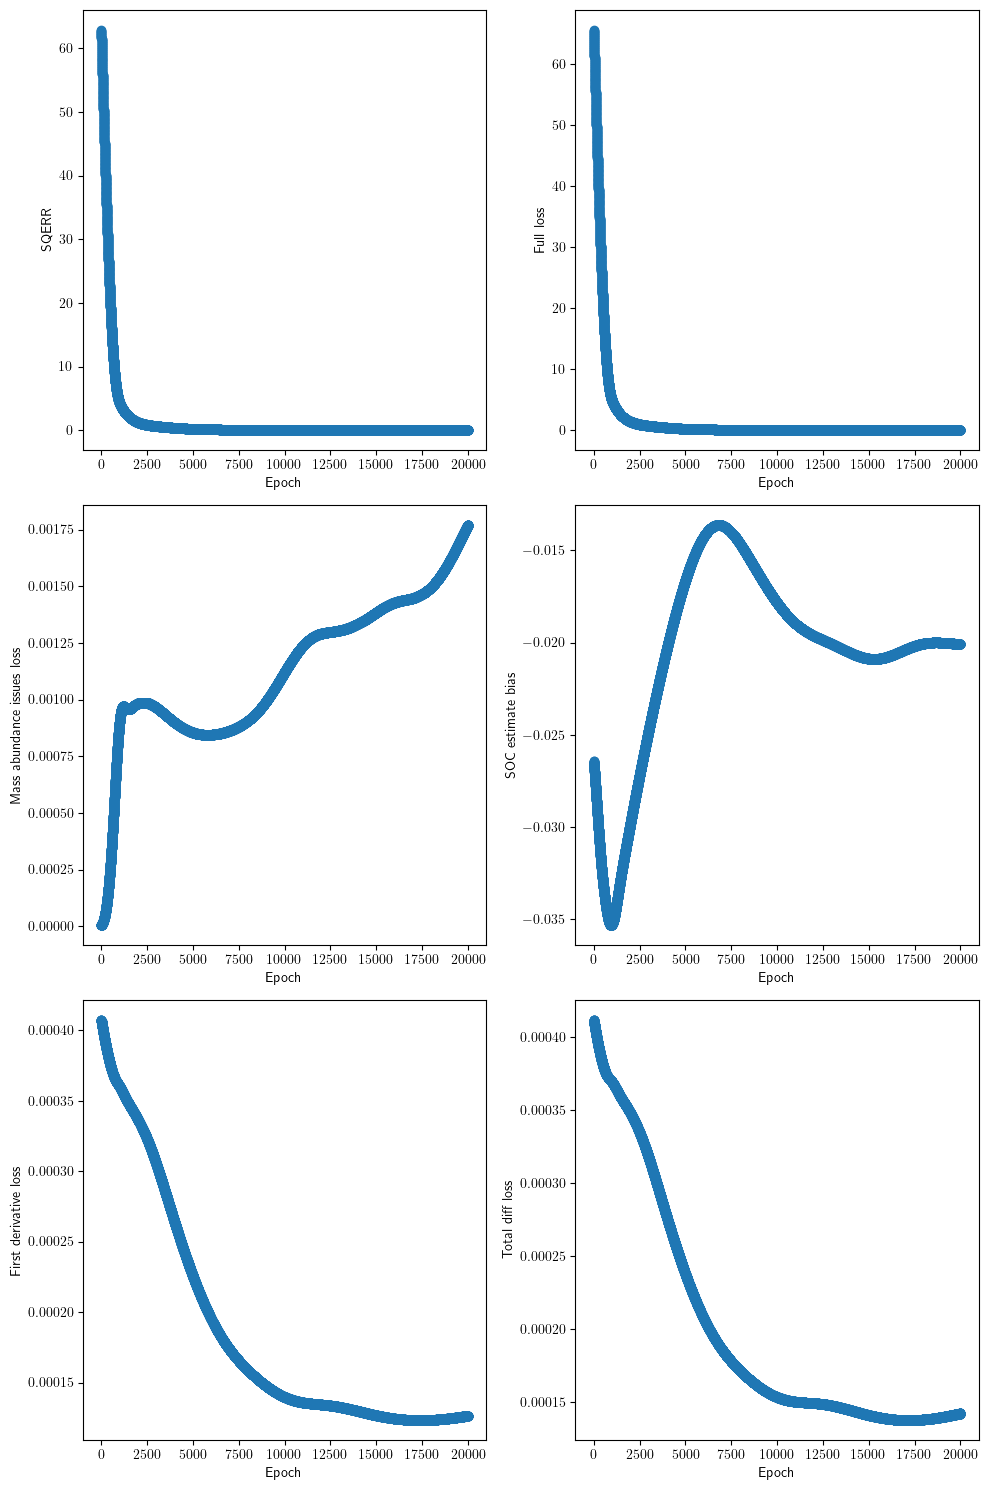

In [109]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq)
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.socbias))],model.socbias)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("SOC estimate bias")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()

In [ ]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(model.ms.detach().numpy().shape[1])):

    col = index % 3
    
    tcorrms = np.array(model.ms.tolist())
    tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
    tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
    
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(tcorrms[:,iEndmember],bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(tcorrms[:,iEndmember])
    sd = np.sqrt(np.var(tcorrms[:,iEndmember]))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()

In [111]:
import pickle

with open('step4_predictions_N1_NpAll_E20k_init.pkl', 'wb') as file:
        pickle.dump((model,optimizer,F,seedMs,seedrrsoc,dataIndices,msoc), file)

In [119]:
import pickle

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,seedMs,seedrrsoc,dataIndices,msoc) = pickle.load(file)

## Serialize analysis

In [ ]:
import pickle

offset = 0

for i in tqdm(range(NData)) :
    
    # generate msoc
    dataIndices = i
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    seedMs, seedrrsoc, seedMsoc = getSeedMs()
    
    # seed data: A[1:,:] and initial F's
    tF       = torch.tensor(F.tolist())
    tseedMs  = torch.tensor(seedMs.tolist())
    tmsoc    = torch.tensor(msoc)
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedrrsoc)

    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = torch.tensor(dataI[dataIndices])

    nepochs = 20000
    model = LinearMixingSOCPredictor(tF, tseedMs, tmsoc, trhorads, trrsoc, nepochs)
    optimizer = optim.Adam(model.parameters(), lr = 0.000005, betas=(0.99,0.999))
    
    print("\t - Training model",i+offset)
    for epoch in tqdm(range(nepochs)) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.05 ** 2) / (NPoints*MSpectra))
    
    with open('step4_predictions_N1_NpAll_E20k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,seedMs,seedrrsoc,dataIndices,msoc), file)
        

In [22]:
gc.collect()

414

In [ ]:
import pickle

offset = 1000

for i in tqdm(range(700)) :
    
    # generate msoc
    dataIndices = np.random.choice(NData,NPoints,replace=False)
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    tempFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
    seedFsoc = tempFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

    # generate new seedMs
    seedMs = genSeedMs()
    
    # generate new seedSOCrr
    seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
    
    # convert to torch
    tF       = torch.tensor(F[:-1,:].tolist())
    tFsoc    = torch.tensor(seedFsoc.tolist())
    tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
    tmsoc    = torch.tensor(msoc.tolist())
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedSOCrr)
    
    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))
    
    # run model fit
    nepochs=100000
    model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
    optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.95,0.9))

    print("\t - Training model",i+offset)
    for epoch in tqdm(range(nepochs)) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.05 ** 2) / (NPoints*MSpectra))
    
    with open('step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)
        

In [71]:
import pickle

rrs=np.zeros([121375])
specs = np.zeros([2151,121375])
#ms = np.zeros([KEndmembers-1,122000])
biases= np.zeros([121375])
msocs= np.zeros([121375])


offset=0

for i in tqdm(range(1,121375)) :
    
    with open('results/step4/step4_predictions_N1_NpAll_E20k_batch_%i.pkl'%(i+offset), 'rb') as file:
        (model,_,_,_,msoc) = pickle.load(file)

        rrs[i] = model.rrsoc.detach().item()
        
        specs[:,i] = np.array(model.Ihat.tolist())
        if np.sum(np.isnan(specs[:,i]).astype('float32')) > 0 :
            print("Spectrum ",i,"is NaN.")
        
        # tcorrms = np.array(model.ms.tolist())
        # tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        # tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
        
        biases[i] = (msoc - (model.ms.detach().tolist()[-1]))/(msoc+0.0001)
        msocs[i]  = model.ms.detach().tolist()[-1]

  0%|          | 0/121374 [00:00<?, ?it/s]

In [16]:
np.mean(biases)

-0.007873499562727506

In [34]:
np.sqrt(np.var([x if np.abs(x) < 10 else 0 for x in biases]))

0.9279589672651445

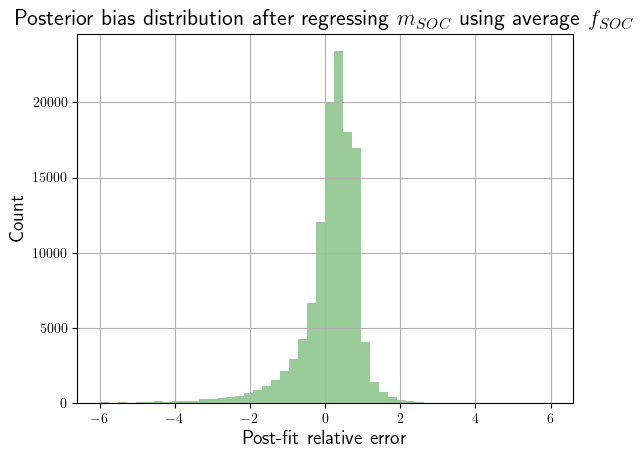

In [39]:
plt.hist(biases, bins=50,range=(-6,6),color='green', alpha=0.4)
plt.xlabel('Post-fit relative error',fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.title("Posterior bias distribution after regressing $m_{SOC}$ using average $f_{SOC}$",fontsize=16)
plt.grid()
           
plt.show()

0.7906809567216204 0.015928237385790328


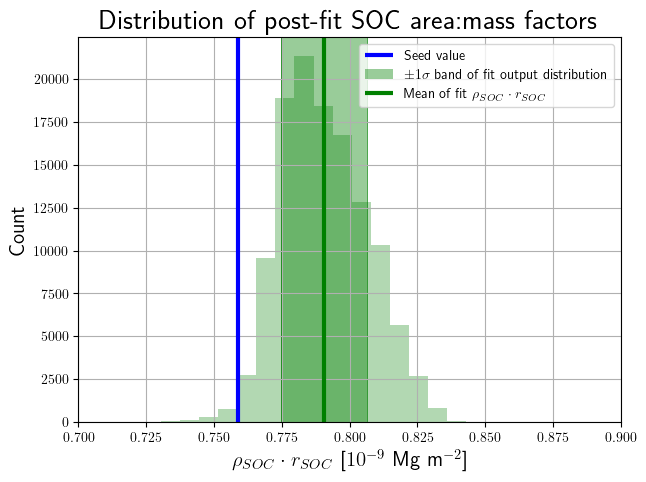

In [78]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

th = plt.hist(np.array(rrs),bins=120,zorder=0,color='green',alpha=0.3)
#plt.vlines(rrs[0],ymin=0,ymax=30,color='orange')
plt.xlim([0.7,0.9])
#plt.yscale('log')
plt.ylim([0,np.max(th[0])*1.05])
plt.grid()

plt.xlabel(r'$\rho_{SOC} \cdot r_{SOC}$ [$10^{-9}$ Mg m$^{-2}$]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of post-fit SOC area:mass factors',fontsize=20)

plt.vlines(seedrrsoc,ymin=0,ymax=np.max(th[0])*1.05,color='blue',label=r'Seed value',lw=3);
#ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.2,label=r'$\pm1\sigma$ band of sampling distribution'));


# Empirical average and variance are computed
avg = np.mean(np.array(rrs))
sd = np.sqrt(np.var(np.array(rrs)))
ax.add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="green",alpha=0.4,label=r'$\pm1\sigma$ band of fit output distribution'));
plt.vlines(avg,ymin=0,ymax=np.max(th[0])*1.05,color='green',label=r'Mean of fit $\rho_{SOC}\cdot r_{SOC}$',lw=3);
#ax.vlines(trueSOCrr*0.8,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
#ax.vlines(trueSOCrr*1.2,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(avg-sd,ymin=0,ymax=np.max(th[0])*1.05,color='green',lw=0.5,zorder=1);
ax.vlines(avg+sd,ymin=0,ymax=np.max(th[0])*1.05,color='green',lw=0.5,zorder=1);

plt.legend(loc='best')
print(avg,sd)

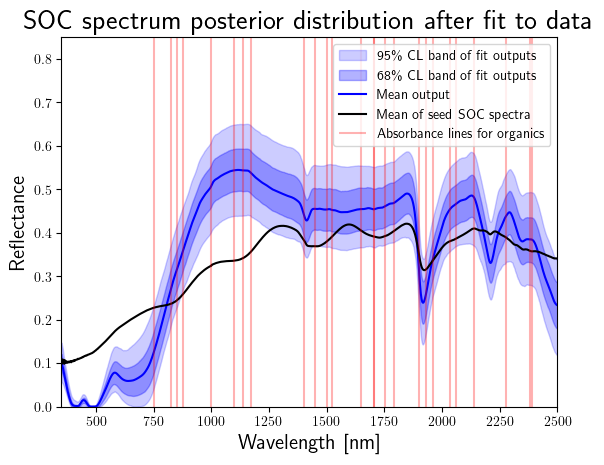

In [95]:
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=1),np.quantile(socspecs,0.005,axis=1),color='blue',alpha=0.1,label=r'99\% CL band')
plt.fill_between(XF,np.quantile(socspecs,0.975,axis=1),np.quantile(socspecs,0.025,axis=1),color='blue',alpha=0.2,label=r'95\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(socspecs,0.84,axis=1),np.quantile(socspecs,0.16,axis=1),color='blue',alpha=0.3,label=r'68\% CL band of fit outputs')

#plt.plot(XF,np.mean(socspecs,axis=1), color='orange',lw=0.5, label=r'Mean of fit outputs');

plt.plot(XF,np.mean(socspecs,axis=1), color='blue', label=r'Mean output');
plt.plot(XF,seedFsoc, color='black', label=r'Mean of seed SOC spectra');

plt.xlim([350.0,2500.0])
plt.ylim([0.0,0.85])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'SOC spectrum posterior distribution after fit to data',fontsize=20)
plt.vlines(organicTroughs,ymin=0.0,ymax=0.85, color='red', alpha=0.3, label="Absorbance lines for organics")

plt.legend(loc='best');

In [81]:
socspecs[:,861] = socspecs[:,862]
socspecs[:,1046] = socspecs[:,1047]
rrs[861] = rrs[862]
rrs[1046] = rrs[1047]

In [82]:
np.min(np.array(rrs))

0.25077817865015944

/home/ecol/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


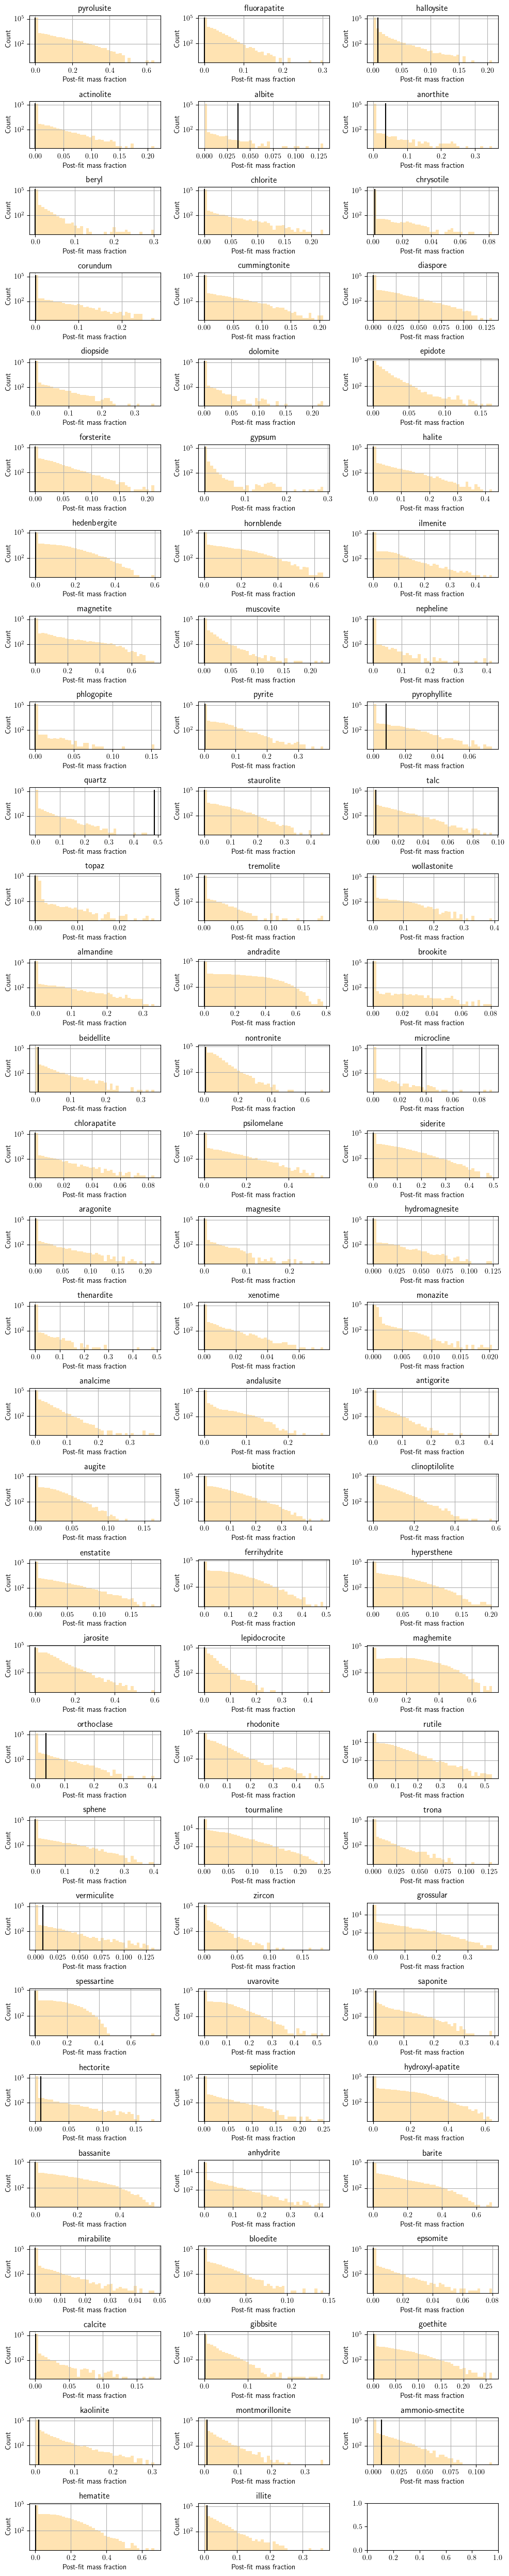

In [96]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in range(ms.shape[1]):

    col = index % 3
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(ms[:,iEndmember,:].flatten(),bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(ms[:,iEndmember,:].flatten())
    sd = np.sqrt(np.var(ms[:,iEndmember,:].flatten()))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()